# Q1: Collision Detection Using Grovers Algorithm

## Problem Setup

You are provided with a system of **3 qubits**, giving you an unstructured quantum search space of:

$$
N = 2^3 = 8 \text{ possible states} \quad (|000⟩, |001⟩, ..., |111⟩)
$$

One of these states — in this case, the state `|101⟩` — represents a **"collision"**, i.e., the correct answer or the marked solution. Your task is to use Grover's algorithm to **identify this collision state** efficiently.

---

## Tasks

You are required to complete the following steps using Python and **Qiskit**:

1. **Initialize the System:**
   - Apply Hadamard gates to all qubits to prepare a uniform superposition over all 8 states.

2. **Construct the Oracle:**
   - Build a quantum oracle that recognizes the collision state `|101⟩` and flips its phase.

3. **Design the Diffusion Operator (Amplitude Amplification):**
    - Implement the diffusion step that inverts amplitudes about their average.

4. **Perform Grover Iterations:**
    - Apply the oracle and diffuser iteratively.
    - Use the theoretical formula:
      $$ r \approx \left\lfloor \frac{\pi}{4} \sqrt{N} \right\rfloor $$
     to determine how many iterations you need.

5. **Measurement and Result:**
    - Measure the final state and confirm that the algorithm amplifies the probability of observing `|101⟩`.

6. **Visualization and Analysis:**
    - Plot the **amplitude evolution** of the target state across iterations.
    - Draw the quantum circuit and final measurement histogram.

## Deliverables
  - Clear inline explanations or markdown cells summarizing.
  - What each section of code is doing.
  - The intuition behind the oracle and diffuser.
  - Why Grover’s algorithm works better than classical search.
  - At least one plot showing the growth of the target state's probability over multiple iterations.


## Bonus Challenge:

  Can you generalize your circuit to work for *any* 3-bit target state, not just `|101⟩`? Can you scale it to 4 qubits and still correctly identify a marked state?


In [11]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import PhaseOracle


In [ ]:
n = 4  
N = 2 ** n # works for 3 and 4
solution = '0100'  # Can be changed to any binary string of length n

In [ ]:
def grover_oracle(n, solution):
    qc = QuantumCircuit(n)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)  
    qc.h(n - 1)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    oracle_gate = qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

In [ ]:
def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1) 
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate

In [15]:
iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(N)))
print(f'Number of Grover iterations: {iterations}')


Number of Grover iterations: 3


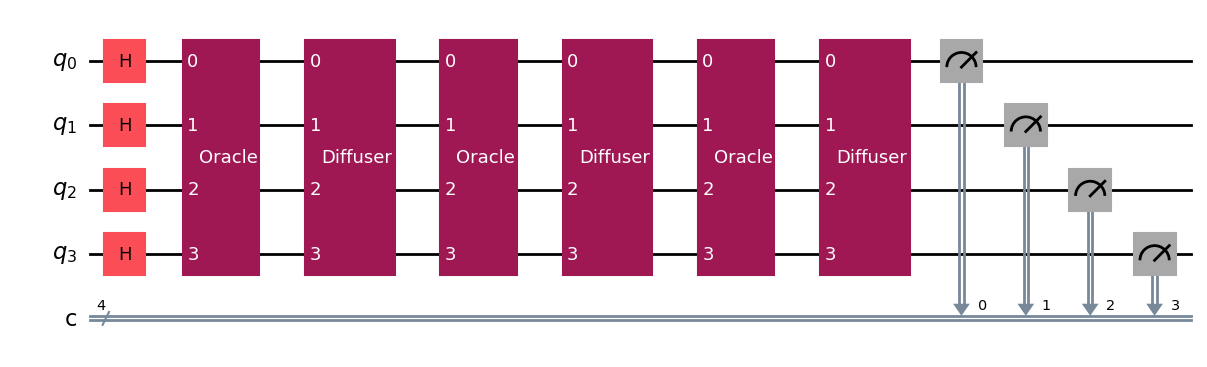

In [ ]:
qc = QuantumCircuit(n, n)

state = Statevector.from_instruction(qc)
amplitudes = []
solution_index = int(solution, 2)

amplitudes.append(np.abs(state.data[solution_index])**2)
qc.h(range(n))

oracle = grover_oracle(n, solution)
diffuser = grover_diffuser(n)

for _ in range(iterations):
    qc.append(oracle, range(n))
    qc.append(diffuser, range(n))
    state = Statevector.from_instruction(qc)
    amp = np.abs(state.data[solution_index])**2
    amplitudes.append(amp)



qc.measure(range(n), range(n))

qc.draw('mpl')

[np.float64(0.0), np.float64(0.47265624999999817), np.float64(0.9084472656249934), np.float64(0.9613189697265532)]


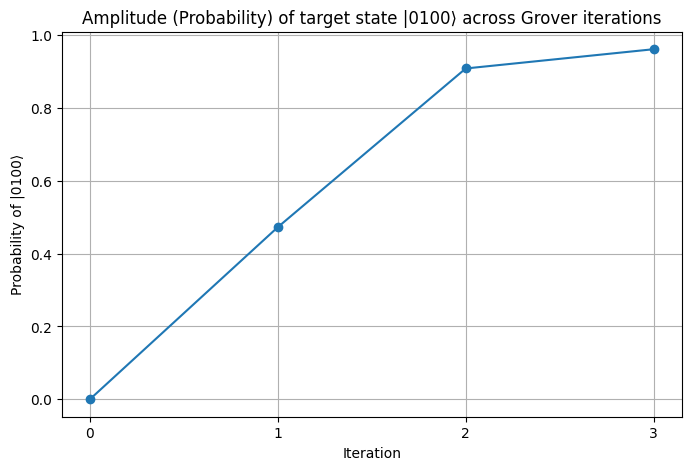

In [17]:
print(amplitudes)
plt.figure(figsize=(8, 5))
plt.plot(range(iterations + 1), amplitudes, marker='o')
plt.title(f"Amplitude (Probability) of target state |{solution}⟩ across Grover iterations")
plt.xlabel("Iteration")
plt.ylabel(f"Probability of |{solution}⟩")
plt.xticks(range(iterations + 1))
plt.grid(True)
plt.show()


{'1001': 3, '1011': 4, '0110': 7, '1010': 4, '0010': 4, '0000': 4, '0101': 6, '0111': 8, '0001': 3, '0011': 3, '1101': 9, '1111': 4, '1100': 6, '0100': 1971, '1000': 6, '1110': 6}


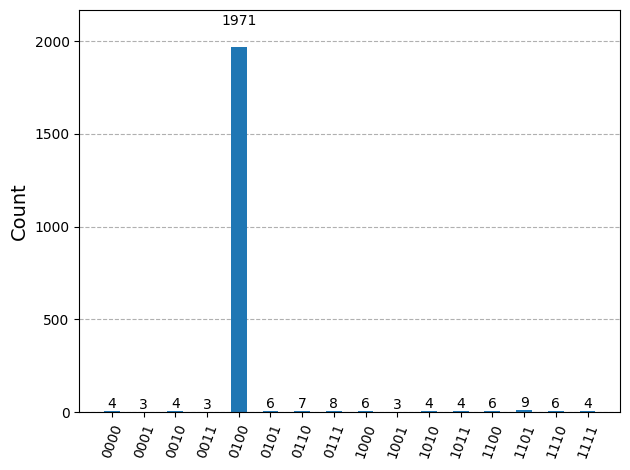

In [18]:
from qiskit import transpile

backend = AerSimulator()
shots = 2048

# Transpile the circuit to the backend's basis gates
transpiled_qc = transpile(qc, backend)

result = backend.run(transpiled_qc, shots=shots).result()
counts = result.get_counts(transpiled_qc)
print(counts)
plot_histogram(counts)

# Q2: Solving a 3-SAT Problem Using Grover's Algorithm

## Context

The Boolean 3-SAT (3-Satisfiability) problem is a foundational example in computational complexity theory. It involves determining whether there exists an assignment of Boolean variables that satisfies a given Boolean formula in conjunctive normal form (CNF), where each clause contains exactly three literals.

3-SAT is a classic NP-complete problem. Solving it efficiently for large instances remains intractable on classical computers. However, quantum computing offers a new approach to tackle such problems using Grover’s search algorithm, which provides a quadratic speedup over classical brute-force search.

In this assignment, you will use Grover's algorithm to find a satisfying assignment for a 3-SAT problem by encoding the Boolean formula into a quantum oracle and searching for an input that satisfies it.

---

## Problem Setup

You are given a Boolean formula of the following form:

$$
(x_1 \lor \lnot x_2 \lor x_3) \land (\lnot x_1 \lor x_2 \lor x_3)$$

This formula has 3 variables: $x_1, x_2, x_3$, leading to $2^3 = 8$ possible input combinations. Your objective is to identify which of these combinations (if any) satisfy the given formula using Grover’s algorithm.

---

## Tasks

1. **Problem Encoding**
- Convert the 3-SAT Boolean formula into a classical Boolean function that returns 1 for satisfying inputs and 0 otherwise.
- Encode this Boolean function into a quantum oracle. You may use Qiskit's `PhaseOracle` or implement your own custom logic.

2. **Circuit Preparation**
- Initialize a uniform superposition over all 2^n basis states using Hadamard gates.
- Construct the full Grover circuit, including the oracle and the diffusion operator.

3. **Iteration Selection**
- Determine the number of Grover iterations using the formula:
     $$ r = \left\lfloor \frac{\pi}{4} \sqrt{\frac{2^n}{M}} \right\rfloor $$

  where $M$ is the number of satisfying solutions. If unknown, use $M = 1$ as an approximation for small cases.

4. **Measurement**
- Add classical registers and measure the quantum state after completing the Grover iterations.
- Simulate the circuit and identify the most probable outputs.

5. **Result Validation**
- Verify whether the measured bitstrings satisfy the original 3-SAT formula.

6. **Visualization and Documentation**
- Draw the quantum circuit using Qiskit's visualization tools.
- Plot the histogram of measurement outcomes.
- Clearly explain each section using markdown cells to document your logic, design choices, and conclusions.

---
## Bonus Challenge

- Extend your implementation to support arbitrary 3-SAT formulas with 3 or more variables.
- Analyze the impact of incorrect estimates of $M$ on the algorithm’s success rate.

---

  ## Important Notes

  Grover’s algorithm does not solve the 3-SAT problem symbolically. Instead, it performs a search over the input space and amplifies the probability of observing a correct solution. The accuracy of your oracle and your iteration count will significantly impact your final results.

Reference : https://quantum.cloud.ibm.com/docs/en/tutorials/grovers-algorithm

In [ ]:
import math
 
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import grover_operator, MCMTGate, ZGate
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, Aer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
import matplotlib.pyplot as plt
 
def grover_oracle(marked_states):

    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    num_qubits = len(marked_states[0])
 
    qc = QuantumCircuit(num_qubits)
    for target in marked_states:
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [
            ind
            for ind in range(num_qubits)
            if rev_target.startswith("0", ind)
        ]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        if zero_inds:
            qc.x(zero_inds)
        qc.compose(MCMTGate(ZGate(), num_qubits - 1, 1), inplace=True)
        if zero_inds:
            qc.x(zero_inds)
    return qc

['000', '001', '011', '101', '110', '111']

Satisfying Assignments: [(0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


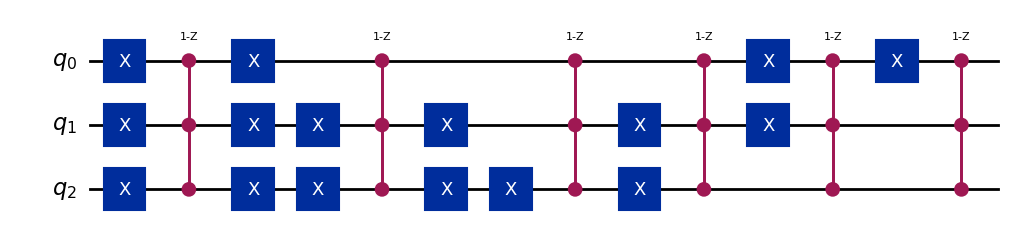

In [ ]:

solutions = []
for i in range(8):
    x1, x2, x3 = (i >> 2) & 1, (i >> 1) & 1, i & 1  
    con1 = x1 or (not x2) or x3
    con2 = (not x1) or x2 or x3
    result = con1 and con2
    if result:
        solutions.append((x1, x2, x3))
formatted_solutions = [''.join(map(str, tup)) for tup in solutions]

print(formatted_solutions)
print("\nSatisfying Assignments:", solutions)

oracle = grover_oracle(formatted_solutions)
oracle.draw(output="mpl", style="iqp")

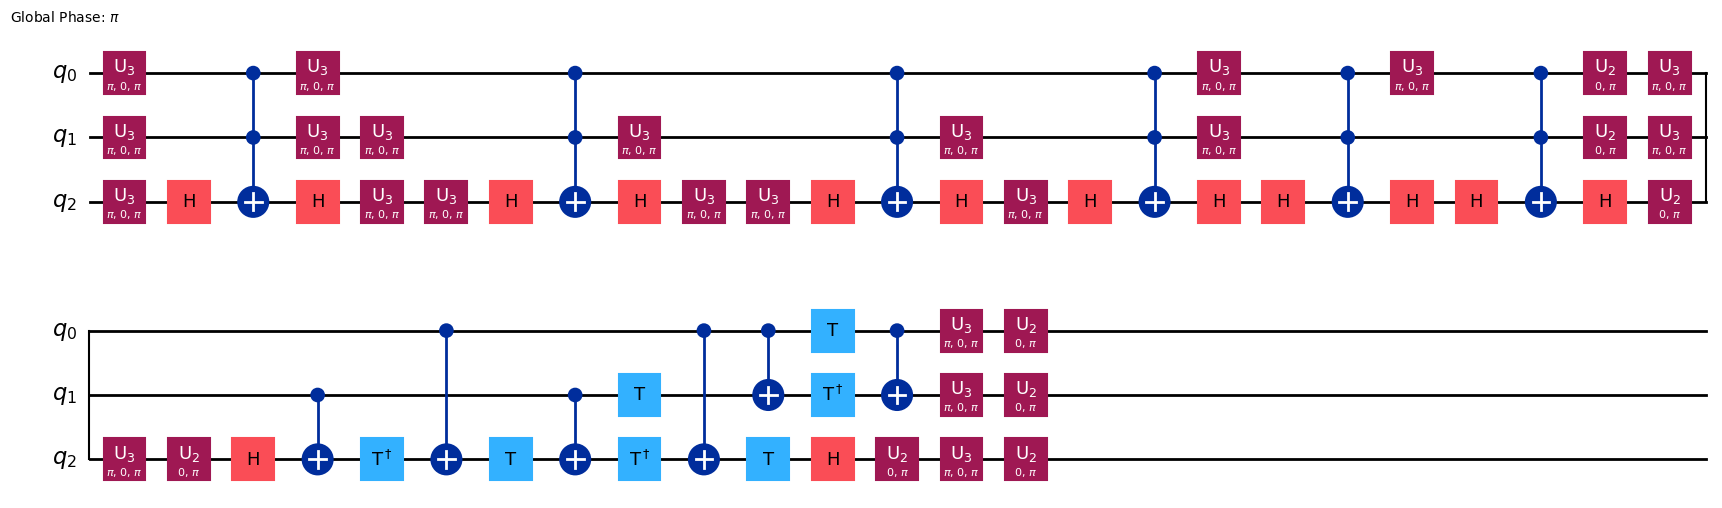

In [4]:
grover_op = grover_operator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [ ]:
optimal_num_iterations = math.floor(
    math.pi
    / (4 * math.asin(math.sqrt(len(formatted_solutions) / 2**grover_op.num_qubits)))
)
optimal_num_iterations = max(optimal_num_iterations, 1) 
print(f"Optimal number of Grover iterations: {optimal_num_iterations}")

Optimal number of Grover iterations: 1


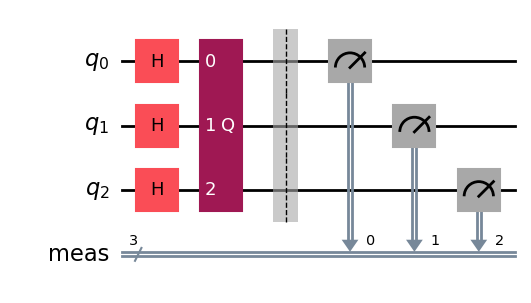

In [ ]:
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-06 18:13:03,842: Default instance not set. Searching all available instances.


Running on: ibm_torino


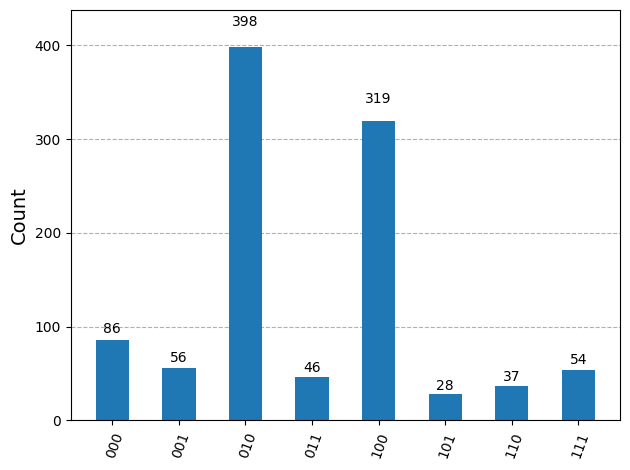

In [ ]:
token = 'b0RwHe1sqhY9CG0KlmZsstY57S6Yu13QkYacPQ3h9z59'
service = QiskitRuntimeService(channel="ibm_cloud", token=token)
backend = service.least_busy(operational=True, min_num_qubits=5)
print("Running on:", backend.name)
simulator = AerSimulator.from_backend(backend=backend)
shots = 2048

ttqc = transpile(qc,backend, optimization_level=2)
sampler = Sampler(mode=backend)
job = sampler.run([ttqc],shots=1024)  
result = job.result()
pub_result = result[0]
counts = pub_result.data.meas.get_counts()
plot_histogram(counts)

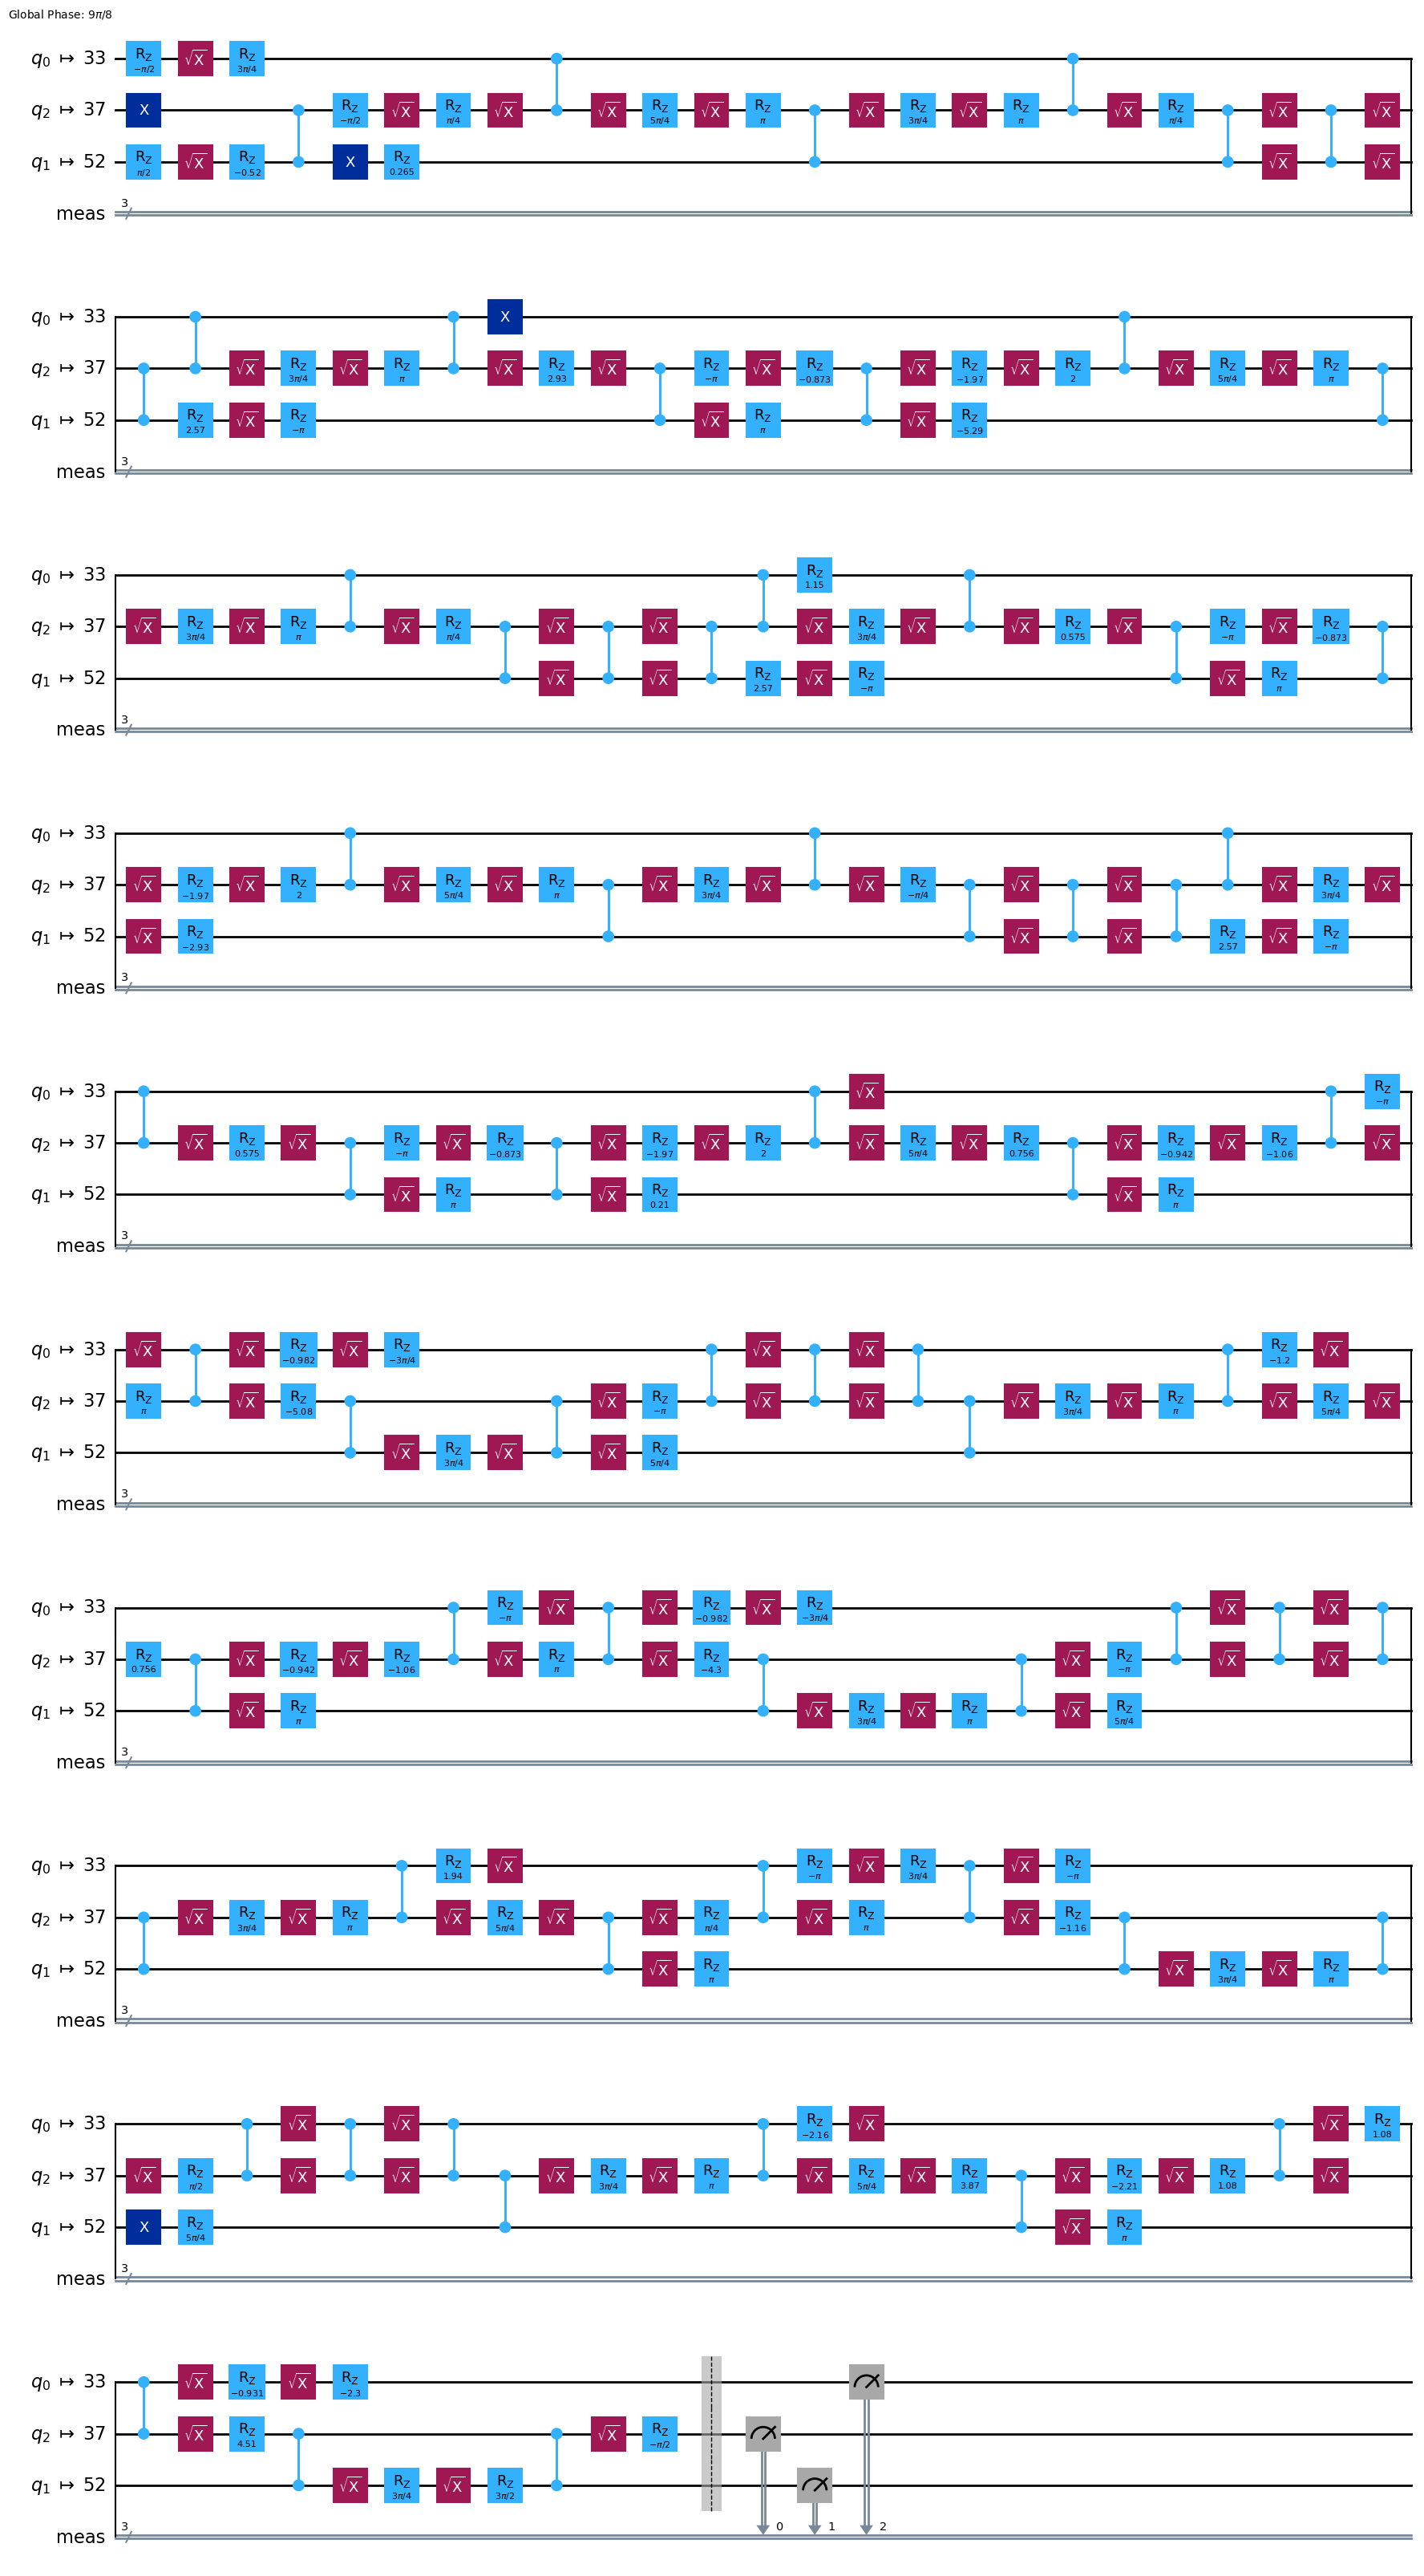

In [8]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [ ]:

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

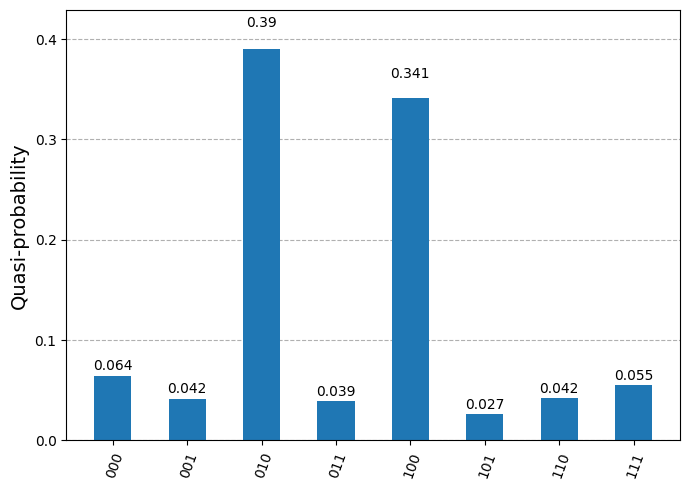

In [10]:
plot_distribution(dist)

So when the number of solutions is more than a certain amount, the Grover algorithm fails to amplify the solutions and ends up amplifying the incorrect solutions.

If the solutions are below a certain limit, then yeah, it works well.

Here is an answer i found online : https://quantumcomputing.stackexchange.com/questions/12790/grovers-algorithm-on-a-database-with-more-than-50-matching-entries